# Notebook 1 - Wavelets and Frequency Information

https://pywavelets.readthedocs.io/en/latest/ref/index.html

## Section 0 - Import libraries, and load metadata and beats

In [ ]:
from multiprocessing import Pool, cpu_count
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import convolve
from sklearn import svm, neighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pywt
import wfdb

from bc.beats import get_beats, get_beat_bank, BEAT_TYPES, SIG_NAMES
from bc.io import ann_to_df
from bc.plot import plot_beat, plot_four_beats

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

# Sampling frequency and period
fs = 360
dt = 1 / fs

In [ ]:
# Load Beats, applying the standard ecg bandpass filter
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='N', filter_beats=True, fixed_width=240)
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='L' ,filter_beats=True, fixed_width=240)
r_beats, r_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='R', filter_beats=True, fixed_width=240)
v_beats, v_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='V', filter_beats=True, fixed_width=240)

sample_beats = [n_beats[0], l_beats[0], r_beats[0], v_beats[0]]

## Section 1 - Explore Wavelets

We are using the `pywt` library. Explore the abailable wavelet families and wavelets.

We have 3 tasks for our continuous wavelet transform:
1. Choose wavelet types that will discern the different beats
2. Choose scales to match the features

In [ ]:
# All wavelet families
print(pywt.families(), '\n')
# All wavelets
print(pywt.wavelist(), '\n')
# All wavelets of a particular family
print(pywt.wavelist(family='bior'), '\n')
# Continuous wavelets
print(pywt.wavelist(kind='continuous'), '\n')

In [ ]:
# Plot the continuous wavelet family functions, excluding complex values ones
for family in pywt.wavelist(kind='continuous'):
    if family not in ['cmor', 'shan', 'fbsp']:
        wavelet = pywt.ContinuousWavelet(family)
        if not wavelet.complex_cwt:
            plt.plot(wavelet.wavefun(level=8)[0])
            plt.title(family)
            plt.show()

In [ ]:
# Visualize one of each beat type to compare with wavelets
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]])

### Question 1: Which wavelets should be used for the continuous wavelet transform?

We will use them to detect the ECG morphologies. It will be most effective to choose ones that are shaped similarly to the various ECG segments.

In [ ]:
# In this exercise, we will select Gaus1 and Gaus2.

### Question 2: Which scales should we use for the continuous wavelet transform?

We want wavelet scales that capture patterns of the relevant frequencies.

Exploring center frequencies of wavelets with scales: [2, 4, 8, 16, 32, 64]
gaus1 wavelet center frequencies: [36.    18.     9.     4.5    2.25   1.125]


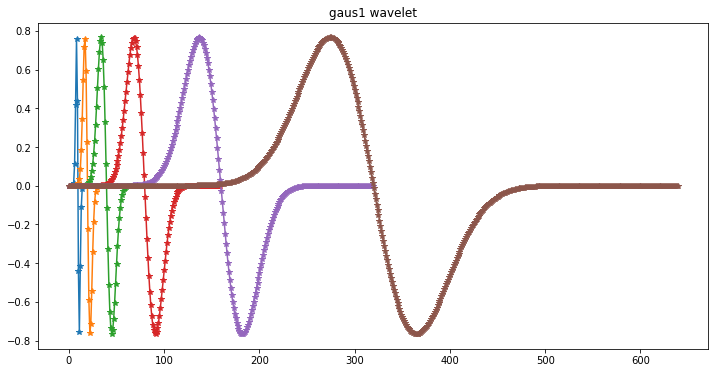

gaus2 wavelet center frequencies: [54.     27.     13.5     6.75    3.375   1.6875]


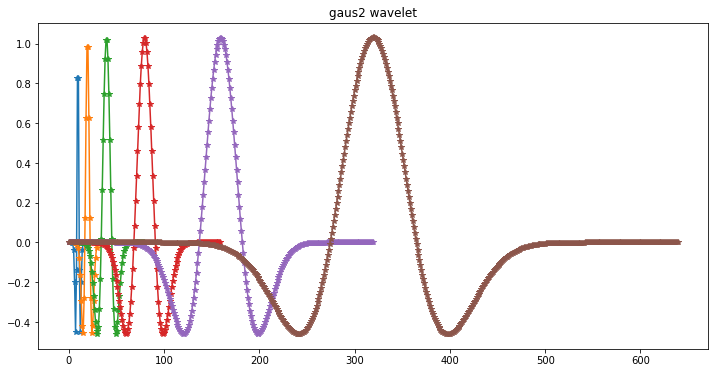

In [3]:
# Regular qrs width is about 0.05s = 0.05 * 360 = 18 samples
# A period of 0.05s corresponds to 1/.05 = 20Hz

wavelet_types = ['gaus1', 'gaus2']
scales = [2, 4, 8, 16, 32, 64]

print('Exploring center frequencies of wavelets with scales:', scales)
for w in wavelet_types:
    wavelet = pywt.ContinuousWavelet(w)
    plt.figure(figsize=(12, 6))
    plt.title('{} wavelet'.format(w))
    f_centers = pywt.scale2frequency(wavelet=w, scale=scales) / dt
    print('{} wavelet center frequencies:'.format(w), f_centers)
#     plt.legend()
    for s in scales:
        psi, _ = wavelet.wavefun(length=int((wavelet.upper_bound - wavelet.lower_bound) * s))
        plt.plot(psi, '*-')
    plt.show()
    
# help(wavelet.wavefun)
# help(pywt.scale2frequency)
# help(pywt.cwt)

In [4]:
# Scales to use for gaus1 and gaus2
ecg_wavelet_scales = [[2, 4, 8, 16, 32, 64], [4, 8, 16, 32, 64]]

In [ ]:
def show_beat_cwt(beat, beat_label):
    """
    Show the CWT applied to both channels of the beat
    at the appropriate scales
    """
    plt.figure(figsize=(18, 12))
    for ch in range(2):
        # Plot the ecg waveform
        plt.subplot(321 + ch)
        plt.plot(beat[:, ch])
        plt.title('{} Beat Signal {}'.format(beat_label, SIG_NAMES[ch]))
        
        # Show the CWT of each wavelet function
        for wnum in range(2):
            coef, freqs = pywt.cwt(beat[:, ch], scales=ecg_wavelet_scales[wnum],
                wavelet=wavelet_types[wnum], sampling_period=dt)
            plt.subplot(323 + ch + wnum*2)
            plt.imshow(coef, cmap='coolwarm', aspect='auto')
            plt.title('{} CWT'.format(wavelet_types[wnum]))
            
            
        

In [ ]:
# Show the CWT applied to each sample beat
for beatnum in range(4):
    show_beat_cwt(beat=sample_beats[beatnum], beat_label=BEAT_TYPES[beatnum])

## Section 2 - Building Features from CWT

In [ ]:
# For each beat, we want a set of features to feed into a classifier
# Each beat will have two wavelet families tested on its two channels.
# We will get the maximum convolution value and the level at which it occurs.
feature_names = ['gaus1_max_II', 'gaus1_max_scale_II', 'gaus2_max_II', 'gaus2_max_scale_II',
            'gaus1_max_V', 'gaus1_max_scale_V', 'gaus2_max_V', 'gaus2_max_scale_V']

FEATURE_NAMES = []

# MAYBE BETTER TO SKIP THIS

# for ch in range(2):
#     for wnum in range(2):
#         for extraction_feature in []
            

In [ ]:
n_features = pd.DataFrame(columns=feature_names)

In [5]:
# def calc_wavelet_features(beat):
#     """
#     Calculate the 8 features for the 2 channel beat
#     """
#     scales = np.arange(1, 30)
#     sig_name = ['MLII', 'V1']
#     features = []
    
#     for ch in range(2):
#         # Reverse channel V1 for qrs complexes to match gaus1 wavelet deflection
#         # Q: Why does this time domain reversal not affect our feature?
#         if ch == 1:
#             sig = - beat[:, ch]
#             #sig = beat[::-1, ch]
#         else:
#             sig = beat[:, ch]
            
#         for wavefun in ['gaus1', 'gaus2']:
#             # Calculate continuous wavelet transform
#             coef, freqs = pywt.cwt(sig, np.arange(1,30), wavefun, sampling_period=1/360)
            
#                         coef, freqs = pywt.cwt(beat[:, ch], scales=ecg_wavelet_scales[wnum],
#                 wavelet=wavelet_types[wnum], sampling_period=dt)
#             # The maximum value of the convolution array
#             max_coef = coef.max()
#             # The scale at which the maximum convolution value occurs
#             max_scale = scales[np.where(coef==max_coef)[0][0]]
#             # Save the features
#             features += [max_coef, max_scale]
#     return features

def calc_cwt_features(beat):
    """
    Calculate the CWT features for the 2 channel beat
    """
    features = []
    for ch in range(2):
        for wnum in range(2):
            # Calculate continuous wavelet transform
            coef, freqs = pywt.cwt(beat[:, ch], scales=ecg_wavelet_scales[wnum],
                                   wavelet=wavelet_types[wnum], sampling_period=dt)
                
            # The maximum and minimum values of the cwt array for each scale,
            # along with their sample indices
            max_coef, min_coef = np.max(coef, axis=1), np.min(coef, axis=1)
            max_ind, min_ind = np.argmax(coef, axis=1), np.argmin(coef, axis=1)
            
            # Append the list of features
            features += max_coef.tolist()
            features += min_coef.tolist()
            features += max_ind.tolist()
            features += min_ind.tolist()
    return features
    

In [6]:
features = calc_cwt_features(n_beats[0])

In [7]:
features

[0.9544232370226094,
 1.7412660117940284,
 2.0159802775480156,
 1.9616422188177385,
 1.6313298596461248,
 0.8737529558626207,
 -1.0547876231154913,
 -1.9280267777618878,
 -2.096179315193711,
 -1.5944930050369344,
 -0.9556192494970452,
 -0.7014530259022678,
 75,
 76,
 79,
 84,
 92,
 93,
 68,
 68,
 66,
 61,
 147,
 2,
 1.689973237895281,
 2.4770032338188375,
 2.3068343339149964,
 1.6034963868865038,
 1.0643577767484071,
 -0.9342036495063519,
 -1.1851065627032111,
 -1.1843944696388586,
 -1.3721890506098486,
 -0.8080031451085432,
 72,
 72,
 73,
 72,
 54,
 65,
 61,
 52,
 114,
 124,
 0.12168329544319127,
 0.20131253944541339,
 0.1980688859546946,
 0.2150957729394296,
 0.14575015882598363,
 0.2324129433756461,
 -0.15564328484088316,
 -0.2709179086816178,
 -0.3049726505402175,
 -0.23107022940640398,
 -0.18806657727186607,
 -0.1583808453438511,
 71,
 70,
 67,
 59,
 44,
 16,
 77,
 78,
 79,
 82,
 95,
 122,
 0.12494540607477028,
 0.191902950015205,
 0.16654825825581865,
 0.12094706222421701,
 0.080

In [ ]:
# Try on some beats
for beat_num in range(len(BEAT_TYPES)):
    features = calc_wavelet_features(sample_beats[beat_num])
    print(BEAT_TYPES[beat_num], features)

## Section 3 - Calculate wavelet features and classify

In [8]:
# Get all the beats and labels together
all_beats = n_beats + l_beats + r_beats + v_beats
labels = [0]*len(n_beats) + [1]*len(l_beats) + [2]*len(r_beats) + [3]*len(v_beats)

In [12]:
# Calculate features for all records using multiple cpus
# pool = Pool(processes=cpu_count() - 1)
# features = pool.map(calc_cwt_features, all_beats)

# Combine features into a data frame
features = pd.DataFrame(features) # , columns=feature_names)
features['type'] = labels

In [13]:
features.shape

(86405, 89)

In [ ]:
# Question: How many rows and columns should the feature matrix have?
features.head()

In [ ]:
# Visualize some results so that we can see if there is any inter-group difference

In [ ]:
# Show some features
for f in feature_names:
    plt.figure()
    for groupnum in range(4):
        plt.hist(features.loc[np.equal(labels, groupnum), f])
    plt.title(f)
    plt.legend(BEAT_TYPES)
    plt.show()
    
# Question: Which features do you think will be more useful?
# Gaus1 is the sinusoud, gaus2 is the hat.


In [14]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=0)
print('Number of training records: %d' % len(x_train))
print('Number of testing records: %d' % len(x_test))

Number of training records: 64803
Number of testing records: 21602


In [ ]:
# LR
t0 = time.time()
clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)
y_predict_lr = clf_lr.predict(x_test)
t_lr = time.time() - t0
print('LR training complete in time {:.2f} seconds'.format(t_lr))

# KNN
t0 = time.time()
clf_knn = neighbors.KNeighborsClassifier()
clf_knn.fit(x_train, y_train)
y_predict_knn = clf_knn.predict(x_test)
t_knn = time.time() - t0
print('KNN training complete in time {:.2f} seconds'.format(t_knn))

# SVM
t0 = time.time()
clf_svm = svm.SVC()
clf_svm.fit(x_train, y_train)
y_predict_svm = clf_svm.predict(x_test)
t_svm = time.time() - t0
print('SVM training complete in time {:.2f} seconds'.format(t_svm))

# And GB
t0 = time.time()
clf_gb = GradientBoostingClassifier()
clf_gb.fit(x_train, y_train)
y_predict_gb = clf_gb.predict(x_test)
t_gb = time.time() - t0
print('GB training complete in time {:.2f} seconds'.format(t_gb))

In [ ]:
# Show final performance
print('Logistic Regression')
print(classification_report(y_test, y_predict_lr, target_names=BEAT_TYPES))

print('K Nearest Neigbors')
print(classification_report(y_test, y_predict_knn, target_names=BEAT_TYPES))

print('Support Vector Machines')
print(classification_report(y_test, y_predict_svm, target_names=BEAT_TYPES))

print('Gradient Boosting')
print(classification_report(y_test, y_predict_gb, target_names=BEAT_TYPES))
